# For audio info

In [158]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [159]:
df = pd.read_csv('output/data/df_audio.csv')
df

,file_path,sampling_rate,rms,dbfs,label,duration
0,./content/LibriSeVoc/gt/3857_180923_000008_000...,24000,0.061510,-24.220951,real,6.840000
1,./content/LibriSeVoc/gt/426_122821_000035_0000...,24000,0.060355,-24.385653,real,6.070000
2,./content/LibriSeVoc/gt/6081_41998_000029_0000...,24000,0.072021,-22.850687,real,11.680000
3,./content/LibriSeVoc/gt/5322_7680_000032_00000...,24000,0.034738,-29.183570,real,5.920000
4,./content/LibriSeVoc/gt/78_369_000026_000000.wav,24000,0.101507,-19.870003,real,9.849958
...,...,...,...,...,...,...
26397,./content/LibriSeVoc/diffwave/3879_173592_0000...,24000,0.068184,-23.326223,fake,7.232000
26398,./content/LibriSeVoc/diffwave/8095_274345_0000...,24000,0.060096,-24.422962,fake,11.370667
26399,./content/LibriSeVoc/diffwave/7794_295948_0000...,24000,0.072218,-22.826923,fake,17.290667
26400,./content/LibriSeVoc/diffwave/6209_34599_00000...,24000,0.079749,-21.965374,fake,6.304000


In [160]:
df.label.value_counts()

label
real    13201
fake    13201
Name: count, dtype: int64

In [161]:
len(df.duration.unique())

5125

In [162]:
df.duration.value_counts()

duration
5.920000     59
5.280000     57
5.130667     55
5.930667     54
6.880000     52
             ..
11.550083     1
22.340000     1
15.300083     1
12.099958     1
17.290667     1
Name: count, Length: 5125, dtype: int64

In [163]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26402 entries, 0 to 26401
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file_path      26402 non-null  object 
 1   sampling_rate  26402 non-null  int64  
 2   rms            26402 non-null  float64
 3   dbfs           26402 non-null  float64
 4   label          26402 non-null  object 
 5   duration       26402 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.2+ MB


In [164]:
df.describe()

,sampling_rate,rms,dbfs,duration
count,26402.0,26402.000000,26402.000000,26402.000000
mean,24000.0,0.060800,-24.741539,9.526883
std,0.0,0.018722,2.791288,4.186767
min,24000.0,0.009805,-40.170113,5.000000
25%,24000.0,0.049083,-26.181149,6.410667
50%,24000.0,0.060280,-24.396368,8.270042
75%,24000.0,0.070954,-22.980284,11.370667
max,24000.0,0.228224,-12.832742,33.258667


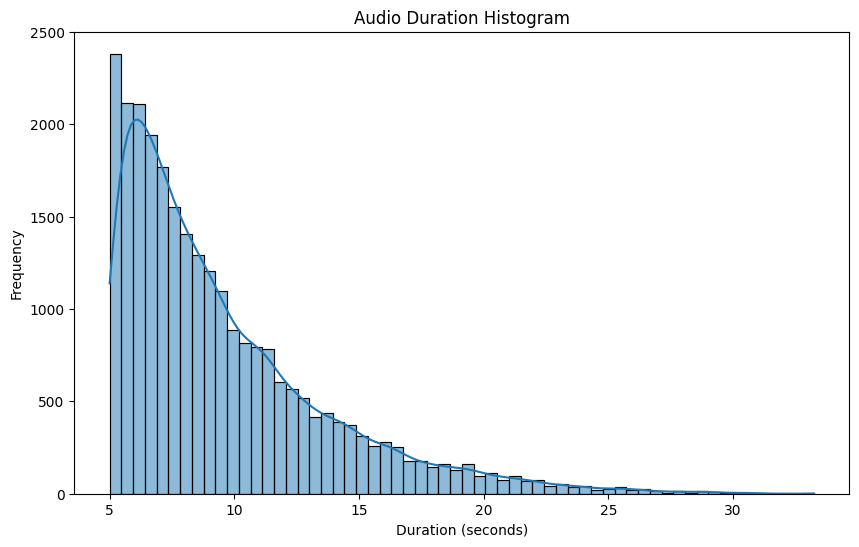

In [165]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=60, kde=True)
plt.title('Audio Duration Histogram')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [166]:
df = df[df['duration'] <= 10]
df

,file_path,sampling_rate,rms,dbfs,label,duration
0,./content/LibriSeVoc/gt/3857_180923_000008_000...,24000,0.061510,-24.220951,real,6.840000
1,./content/LibriSeVoc/gt/426_122821_000035_0000...,24000,0.060355,-24.385653,real,6.070000
3,./content/LibriSeVoc/gt/5322_7680_000032_00000...,24000,0.034738,-29.183570,real,5.920000
4,./content/LibriSeVoc/gt/78_369_000026_000000.wav,24000,0.101507,-19.870003,real,9.849958
5,./content/LibriSeVoc/gt/39_121915_000013_00000...,24000,0.027996,-31.057756,real,5.529958
...,...,...,...,...,...,...
26394,./content/LibriSeVoc/diffwave/7447_91186_00002...,24000,0.057005,-24.881546,fake,9.034667
26395,./content/LibriSeVoc/diffwave/6367_65536_00003...,24000,0.073831,-22.635100,fake,7.136000
26397,./content/LibriSeVoc/diffwave/3879_173592_0000...,24000,0.068184,-23.326223,fake,7.232000
26400,./content/LibriSeVoc/diffwave/6209_34599_00000...,24000,0.079749,-21.965374,fake,6.304000


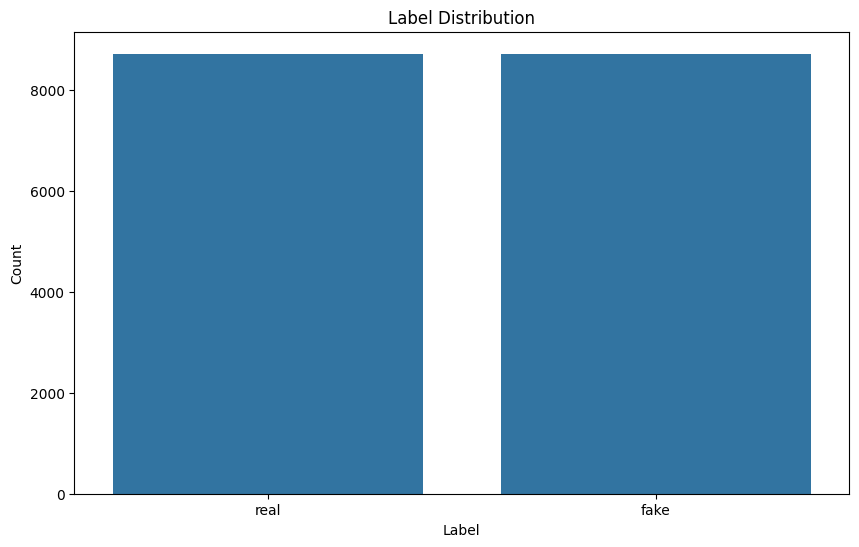

In [167]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# For features file

In [168]:
df_features = pd.read_csv('./output/data/features_augmented.csv')

In [169]:
features = df_features.drop(columns=['label', 'file_path', 'sampling_rate', 'mfcc_3_mean', 'mfcc_24_mean', 'mfcc_25_mean', 'mfcc_26_mean',
                                     'mfcc_27_mean', 'mfcc_28_mean', 'mfcc_29_mean', 'mfcc_30_mean'], axis=1).copy()
labels = df_features['label']

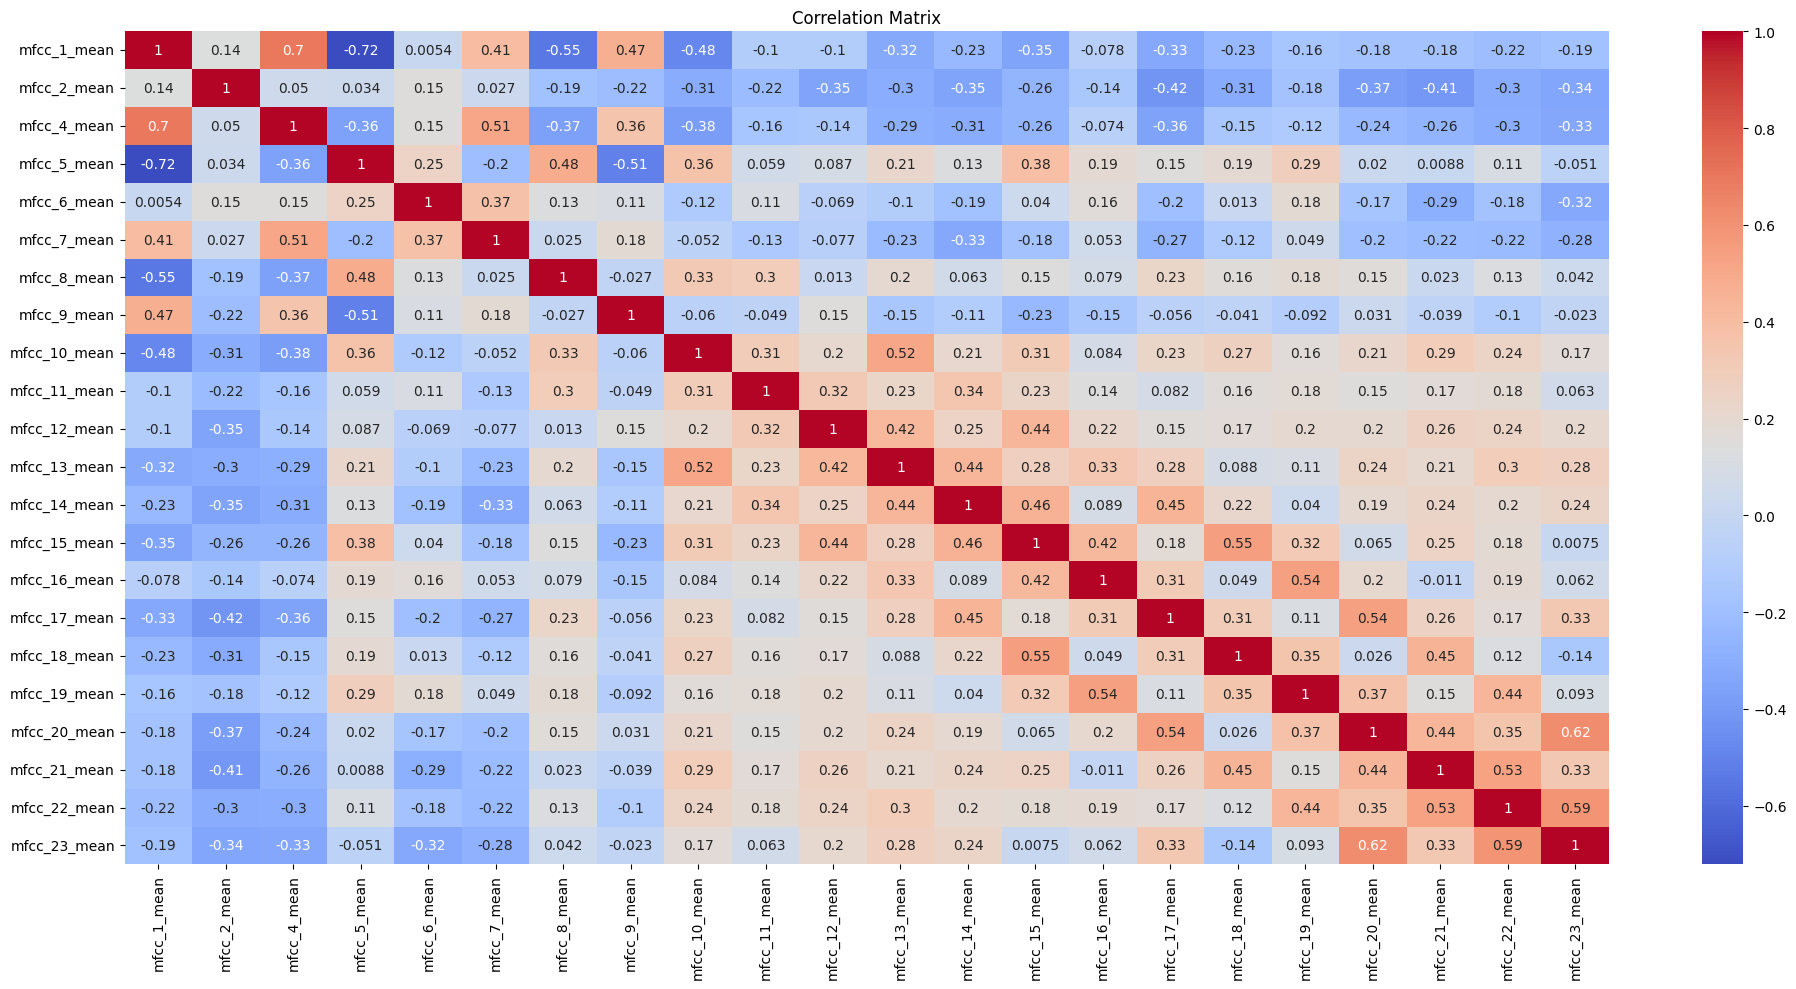

In [170]:
correlation_matrix = features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Augment data

In [171]:
# import numpy as np

# # Define the noise factor
# noise_factor = 0.01

# # Add noise to the features
# df_features.iloc[:, 3:25] += noise_factor * np.random.normal(loc=0.0, scale=1.0, size=df_features.iloc[:, 3:25].shape)

# # Display the noisy features
# df_features.head()

# Merging

In [172]:
merged_df = pd.merge(df, df_features.drop(columns=['sampling_rate', 'label']), on='file_path')
merged_df.describe()

,sampling_rate,rms,dbfs,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
count,17423.0,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,...,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000
mean,24000.0,0.061057,-24.721248,7.109606,-255.319276,134.347713,-70.851749,15.657646,-10.775211,-32.887672,...,-7.795758,-7.280199,-5.864474,-5.186482,-4.359597,-3.385051,-2.661149,-1.996101,-1.506335,-0.964773
std,0.0,0.019329,2.834867,1.395377,54.183525,13.590455,29.684011,13.426525,12.412177,7.795539,...,2.410358,2.426280,2.816014,2.695143,2.664429,3.094316,2.968805,2.962144,3.078672,3.111786
min,24000.0,0.010383,-39.672676,5.000000,-408.118380,56.237162,-137.430569,-41.652532,-48.188954,-69.163510,...,-18.902820,-15.746855,-16.632511,-18.109995,-14.691298,-14.261384,-12.108825,-15.909237,-9.870514,-12.197507
25%,24000.0,0.048934,-26.207538,5.920000,-302.887242,127.104678,-94.412411,6.945891,-20.445150,-37.373617,...,-9.339551,-8.860002,-7.618287,-6.959204,-6.108841,-5.459085,-4.686299,-3.997374,-3.634981,-3.128199
50%,24000.0,0.060369,-24.383595,6.920042,-243.857149,134.998394,-79.069589,17.312804,-12.204050,-32.682093,...,-8.021398,-7.562231,-6.234768,-5.552792,-4.777987,-4.013457,-3.221568,-2.510843,-2.174444,-1.583863
75%,24000.0,0.071295,-22.938708,8.224000,-210.556362,142.539097,-45.476400,25.071745,-1.470539,-28.083520,...,-6.477227,-6.028319,-4.535587,-3.744780,-3.031034,-1.947341,-1.227466,-0.500177,0.003076,0.643827
max,24000.0,0.228224,-12.832742,10.000000,-123.426107,186.151390,22.071994,60.470294,34.210128,-3.602366,...,5.730917,8.347262,11.216076,9.072880,12.053819,16.753368,17.680922,14.196784,15.971198,17.845168


In [173]:
merged_df.columns

Index(['file_path', 'sampling_rate', 'rms', 'dbfs', 'label', 'duration',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

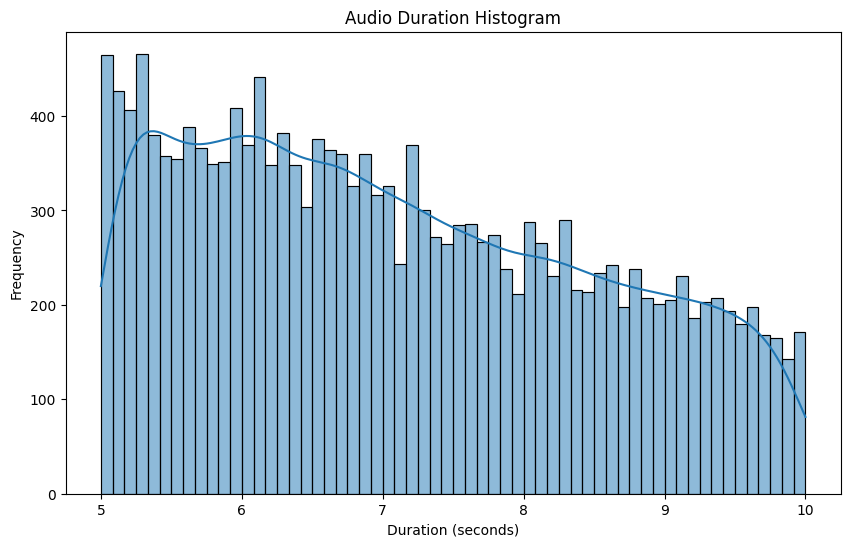

In [174]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['duration'], bins=60, kde=True)
plt.title('Audio Duration Histogram')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [175]:
merged_df.to_csv('./output/data/merged_df.csv', index=False)

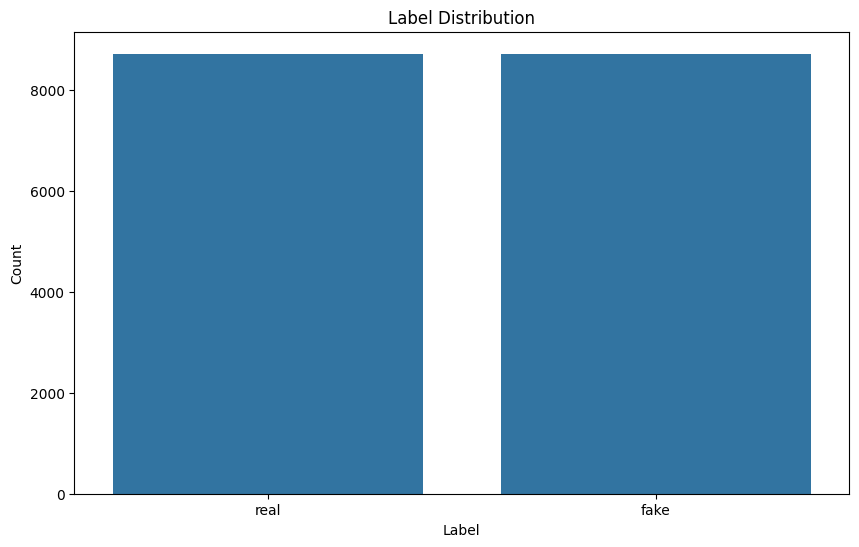

In [176]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=merged_df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()